# Outlier analysis

The purpose of this notebook is to analyze the dataset of Human, to find potential outliers.

## Imports

In [10]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
)
from subpred.util import get_clusters, perform_pca, get_protein_feature_stats
import numpy as np

## Creating the dataset

In [11]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [9606],
    output_log = "../logs/human_amino_sugar_dataset.log",
)

In [3]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,0.0,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9BRV3,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC50A1 RAG1AP1 SCP,Sugar transporter SWEET1 (HsSWEET1) (RAG1-acti...,2.A.123.1.4,2.A,9606,MEAGGFLDSLIYGACVVFTLGMFSAGLSDLRHMRMTRSVDNVQFLP...
Q5M8T2,Sugar transport,Membrane;Transmembrane,Transport,SLC35D3 FRCL1,Solute carrier family 35 member D3 (Fringe con...,2.A.7.15.5,2.A,9606,MRQLCRGRVLGISVAIAHGVFSGSLNILLKFLISRYQFSFLTLVQC...
Q969S0,Sugar transport,Membrane;Transmembrane,Transport,SLC35B4 YEA4 PSEC0055,UDP-xylose and UDP-N-acetylglucosamine transpo...,2.A.7.10.2,2.A,9606,MRPALAVGLVFAGCCSNVIFLELLARKHPGCGNIVTFAQFLFIAVE...
O75387,Amino-acid transport,Membrane;Transmembrane,Transport,SLC43A1 LAT3 PB39 POV1,Large neutral amino acids transporter small su...,2.A.1.44.1,2.A,9606,MAPTLQQAYRRRWWMACTAVLENLFFSAVLLGWGSLLIILKNEGFY...


In [17]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)

### Stats

The dataset is imbalanced, and generally has a relatively low number of samples per class. 30 samples per class is just barely above the threshold for creating a suitable model (see clustering notebooks AT and EC).

In [4]:
df.keywords_transport.value_counts()

Amino-acid transport                                                              36
Sugar transport                                                                   30
Amino-acid transport;Ion transport;Sodium transport                                9
Ion transport;Sodium transport;Sugar transport                                     4
Amino-acid transport;Chloride                                                      4
Amino-acid transport;Neurotransmitter transport                                    3
Amino-acid transport;Ion transport;Neurotransmitter transport;Sodium transport     1
Name: keywords_transport, dtype: int64


Some proteins also transport ions. Are they barrel proteins?

In [12]:
df[df.keywords_transport.str.contains("Ion")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q96QD8,Amino-acid transport;Ion transport;Sodium tran...,Cell membrane;Membrane;Transmembrane,Symport;Transport,SLC38A2 ATA2 KIAA1382 SAT2 SNAT2,Sodium-coupled neutral amino acid transporter ...,2.A.18.6.5,2.A,9606,MKKAEMGRFSISPDEDSSSYSSNSDFNYSYPTKQAALKSHYADVDP...
Q9H2H9,Amino-acid transport;Ion transport;Sodium tran...,Cell membrane;Membrane;Transmembrane,Symport;Transport,SLC38A1 ATA1 NAT2 SAT1 SNAT1,Sodium-coupled neutral amino acid transporter ...,2.A.18.6.14,2.A,9606,MMHFKSGLELTELQNMTVPEDDNISNDSNDFTEVENGQINSKFISD...
Q969I6,Amino-acid transport;Ion transport;Sodium tran...,Cell membrane;Membrane;Transmembrane,Symport;Transport,SLC38A4 ATA3 NAT3 SNAT4,Sodium-coupled neutral amino acid transporter ...,2.A.18.6.17,2.A,9606,MDPMELRNVNIEPDDESSSGESAPDSYIGIGNSEKAAMSSQFANED...
Q8IZM9,Amino-acid transport;Ion transport;Sodium tran...,Cell membrane;Membrane;Transmembrane,Transport,SLC38A6 NAT1 SNAT6,Probable sodium-coupled neutral amino acid tra...,2.A.18.6.11,2.A,9606,MEASWGSFNAERGWYVSVQQPEEAEAEELSPLLSNELHRQRSPGVS...
Q9NVC3,Amino-acid transport;Ion transport;Sodium tran...,Membrane;Transmembrane,Transport,SLC38A7 SNAT7,Putative sodium-coupled neutral amino acid tra...,2.A.18.6.13,2.A,9606,MAQVSINNDYSEWDLSTDAGERARLLQSPCVDTAPKSEWEASPGGL...
Q99624,Amino-acid transport;Ion transport;Sodium tran...,Cell membrane;Membrane;Transmembrane,Antiport;Symport;Transport,SLC38A3 G17 NAT1 SN1 SNAT3,Sodium-coupled neutral amino acid transporter ...,2.A.18.6.3,2.A,9606,MEAPLQTEMVELVPNGKHSEGLLPVITPMAGNQRVEDPARSCMEGK...
Q9H2J7,Amino-acid transport;Ion transport;Neurotransm...,Membrane;Transmembrane,Symport;Transport,SLC6A15 B0AT2 NTT73 SBAT1,Sodium-dependent neutral amino acid transporte...,2.A.22.6.7,2.A,9606,MPKNSKVVKRELDDDVTESVKDLLSNEDAADDAFKTSELIVDGQEE...
A6NNN8,Amino-acid transport;Ion transport;Sodium tran...,Membrane;Transmembrane,Transport,SLC38A8,Putative sodium-coupled neutral amino acid tra...,2.A.18.6.12,2.A,9606,MEGQTPGSRGLPEKPHPATAAATLSSMGAVFILMKSALGAGLLNFP...
Q5TF39,Ion transport;Sodium transport;Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,MFSD4B KIAA1919 NAGLT1 HSPC100,Sodium-dependent glucose transporter 1 (Major ...,2.A.1.7.27,2.A,9606,MLCASFLGLGLSVAIVGPTFQDLATNVNRNISSLSFIFVGRALGYL...


Their TCDB identifiers (passive transport) and the fact that they belong to the solute carriers (SLC) family confirm that they do not contain barrel proteins, just alpha-helical bundles. The structures from alphafold and pdb confirm this. We'll see if the sodium-coupled proteins form their own cluster later.

What about the neurotransmitters?

In [14]:
df[df.keywords_transport.str.contains("Neuro")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9H2J7,Amino-acid transport;Ion transport;Neurotransm...,Membrane;Transmembrane,Symport;Transport,SLC6A15 B0AT2 NTT73 SBAT1,Sodium-dependent neutral amino acid transporte...,2.A.22.6.7,2.A,9606,MPKNSKVVKRELDDDVTESVKDLLSNEDAADDAFKTSELIVDGQEE...
Q99884,Amino-acid transport;Neurotransmitter transport,Membrane;Transmembrane,Symport;Transport,SLC6A7 PROT,Sodium-dependent proline transporter (Solute c...,2.A.22.2.11,2.A,9606,MKKLQGAHLRKPVTPDLLMTPSDQGDVDLDVDFAAHRGNWTGKLDF...
P48067,Amino-acid transport;Neurotransmitter transport,Membrane;Transmembrane,Symport;Transport,SLC6A9,Sodium- and chloride-dependent glycine transpo...,2.A.22.2.12,2.A,9606,MSGGDTRAAIARPRMAAAHGPVAPSSPEQVTLLPVQRSFFLPPFSG...
Q96N87,Amino-acid transport;Neurotransmitter transport,Membrane;Transmembrane,Symport;Transport,SLC6A18 XTRP2,Inactive sodium-dependent neutral amino acid t...,2.A.22.6.4,2.A,9606,MAHAPEPDPAACDLGDERPKWDNKAQYLLSCTGFAVGLGNIWRFPY...


It seems like they are normal amino-acid transporters, except that they occur in synaptic cells, where the amino acids act as neurotransmitters.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

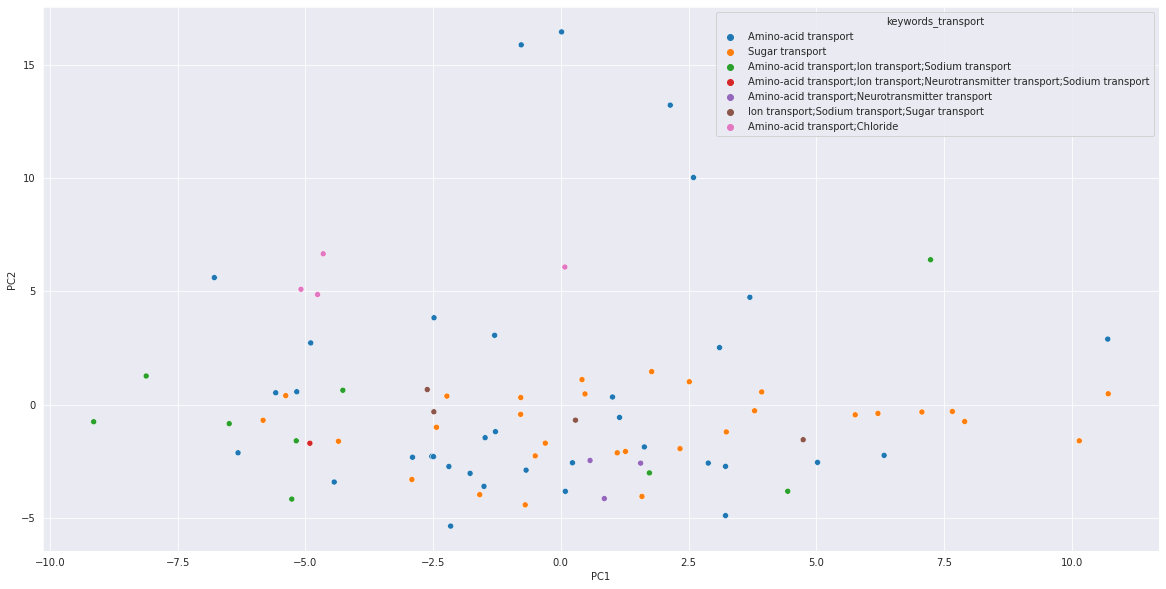

In [34]:
pca_plot_2d(df_paac, df.keywords_transport, figsize=(20,10))

#### Locations

In [15]:
df.keywords_location.value_counts()

Membrane;Transmembrane                                               38
Cell membrane;Membrane;Transmembrane                                 36
Endoplasmic reticulum;Membrane;Transmembrane                          6
Membrane;Mitochondrion;Transmembrane                                  4
Membrane;Mitochondrion;Mitochondrion inner membrane;Transmembrane     3
Name: keywords_location, dtype: int64

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

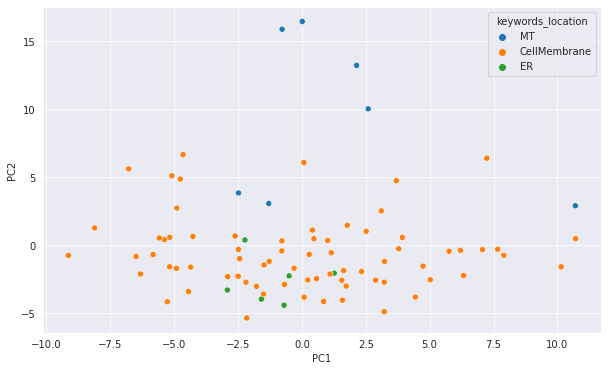

In [28]:
pca_plot_2d(df_paac, df.keywords_location.transform(lambda x: "MT" if "Mito" in x else ("ER" if "Endo" in x else "CellMembrane")))

MT transporters can be barrel proteins, is that the case here?

In [16]:
df[df.keywords_location.str.contains("Mito")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,0.0,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q96NB2,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN2,Sideroflexin-2,2.A.54.1.8,2.A,9606,MEADLSGFNIDAPRWDQRTFLGRVKHFLNITDPRTVFVSERELDWA...
Q96H78,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SLC25A44 KIAA0446,Solute carrier family 25 member 44,2.A.29.14.7,2.A,9606,MEDKRNIQIIEWEHLDKKKFYVFGVAMTMMIRVSVYPFTLIRTRLQ...
Q8TD22,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN5,Sideroflexin-5,NaN,0.0,9606,MADTATTASAAAASAASASSDAPPFQLGKPRFQQTSFYGRFRHFLD...
Q6P4A7,Amino-acid transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Transport,SFXN4 BCRM1,Sideroflexin-4 (Breast cancer resistance marke...,2.A.54.1.3,2.A,9606,MSLEQEEETQPGRLLGRRDAVPAFIEPNVRFWITERQSFIRRFLQW...
Q9H9B4,Amino-acid transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Transport,SFXN1,Sideroflexin-1,2.A.54.1.1,2.A,9606,MSGELPPNINIKEPRWDQSTFIGRANHFFTVTDPRNILLTNEQLES...
Q8N8R3,Amino-acid transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Transport,SLC25A29 C14orf69 ORNT3,Mitochondrial basic amino acids transporter (C...,2.A.29.8.9,2.A,9606,MALDFLAGCAGGVAGVLVGHPFDTVKVRLQVQSVEKPQYRGTLHCF...


No, both the sideroflexin and SLC proteins look normal in terms of structure. What about their sequences?

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

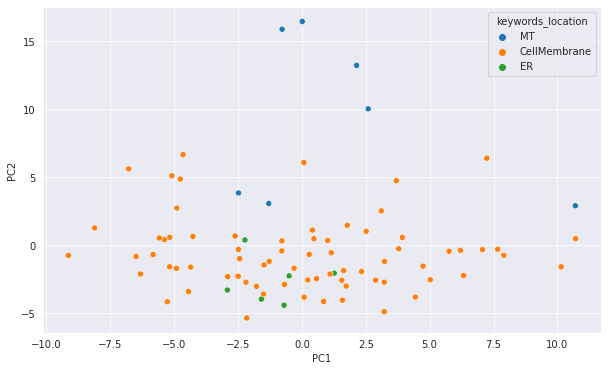

In [ ]:
pca_plot_2d(df_paac, df.keywords_location.transform(lambda x: "MT" if "Mito" in x else ("ER" if "Endo" in x else "CellMembrane")))

ER proteins look good for now. In terms of PAAC, there are four MT proteins that have a slightly higher PC2 value. Are those the Sidoeroflexins? 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

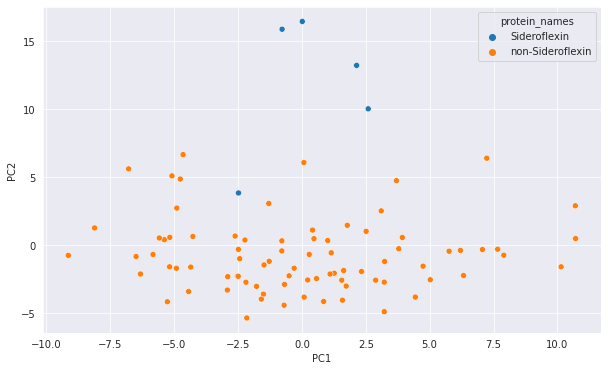

In [40]:
pca_plot_2d(df_paac, df.protein_names.transform(lambda x: "Sideroflexin" if "Sideroflexin" in x else "non-Sideroflexin"))

Yes, those are four of the five the Sideroflexins. They might be outliers in terms of sequence. How do they look in a h. clustering?

({'Sideroflexin': 'cyan', 'non-Sideroflexin': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f46d86af2b0>)

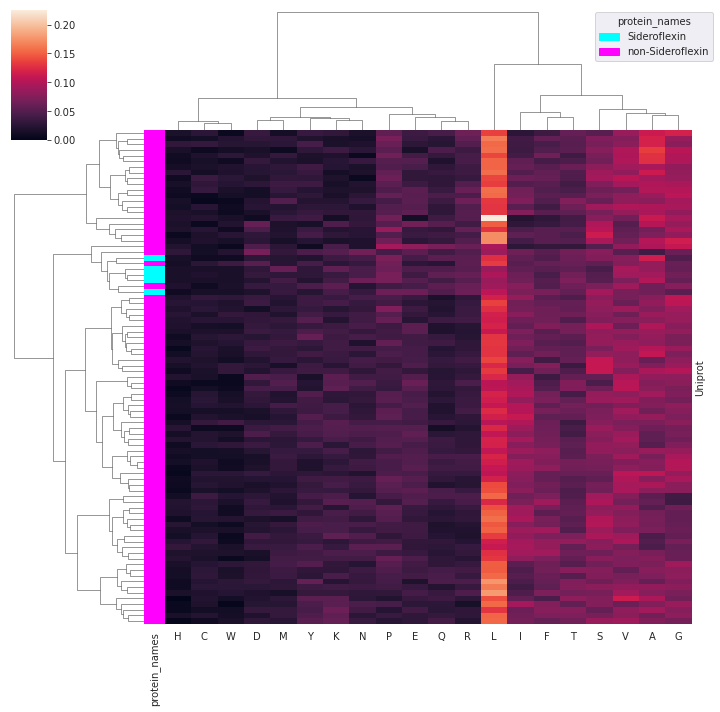

In [47]:
labeled_clustermap(df_aac, df.protein_names.transform(lambda x: "Sideroflexin" if "Sideroflexin" in x else "non-Sideroflexin"), xlabels="auto")

When looking at the AAC heatmap, they are in a small sub-cluster, but do not look too much different from the remaining dataset. What about the correlation matrix?

({'Sideroflexin': 'cyan', 'non-Sideroflexin': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f46d1f4be20>)

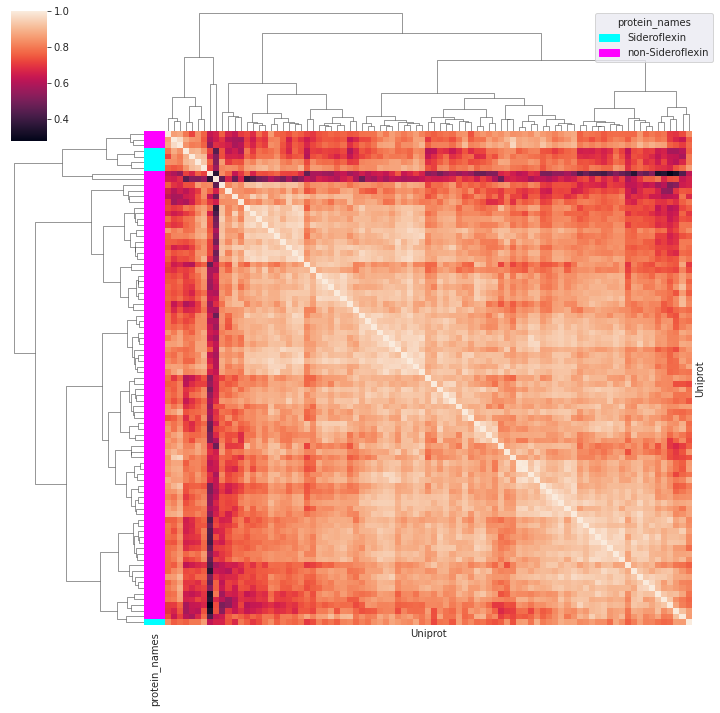

In [46]:
labeled_clustermap(df_aac.T.corr(), df.protein_names.transform(lambda x: "Sideroflexin" if "Sideroflexin" in x else "non-Sideroflexin"))

There is one cluster of correlation coefficients, what proteins are those?

In [53]:
cluster1, cluster2 = get_clusters(df_aac.T.corr(), 2)

print(len(cluster1))
print(len(cluster2))

df.loc[cluster2]

78
9


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,0.0,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q96NB2,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN2,Sideroflexin-2,2.A.54.1.8,2.A,9606,MEADLSGFNIDAPRWDQRTFLGRVKHFLNITDPRTVFVSERELDWA...
Q96H78,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SLC25A44 KIAA0446,Solute carrier family 25 member 44,2.A.29.14.7,2.A,9606,MEDKRNIQIIEWEHLDKKKFYVFGVAMTMMIRVSVYPFTLIRTRLQ...
Q8TD22,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN5,Sideroflexin-5,NaN,0.0,9606,MADTATTASAAAASAASASSDAPPFQLGKPRFQQTSFYGRFRHFLD...
Q9H9B4,Amino-acid transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Transport,SFXN1,Sideroflexin-1,2.A.54.1.1,2.A,9606,MSGELPPNINIKEPRWDQSTFIGRANHFFTVTDPRNILLTNEQLES...
Q9HBR0,Amino-acid transport;Ion transport;Sodium tran...,Membrane;Transmembrane,Transport,SLC38A10 PP1744,Putative sodium-coupled neutral amino acid tra...,2.A.18.6.16,2.A,9606,MTAAAASNWGLITNIVNSIVGVSVLTMPFCFKQCGIVLGALLLVFC...
Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,8.A,9606,MAEDKSKRDSIEMSMKGCQTNNGFVHNEDILEQTPDPGSSTDNLKH...
P43003,Amino-acid transport;Chloride,Cell membrane;Membrane;Transmembrane,Symport;Transport,SLC1A3 EAAT1 GLAST GLAST1,Excitatory amino acid transporter 1 (Sodium-de...,2.A.23.2.6,2.A,9606,MTKSNGEEPKMGGRMERFQQGVRKRTLLAKKKVQNITKEDVKSYLF...
P43005,Amino-acid transport;Chloride,Cell membrane;Membrane;Transmembrane,Symport;Transport,SLC1A1 EAAC1 EAAT3,Excitatory amino acid transporter 3 (Excitator...,2.A.23.2.3,2.A,9606,MGKPARKGCEWKRFLKNNWVLLSTVAAVVLGITTGVLVREHSNLST...


Again the four Sideroflexins with the high PC2 value, and some mutli-substrate amino acid transporters. One protein that stands out is RBAT, which is assigned to TCDB class 8 (accessory factors to transport). How do the clusters look in the PCA?

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

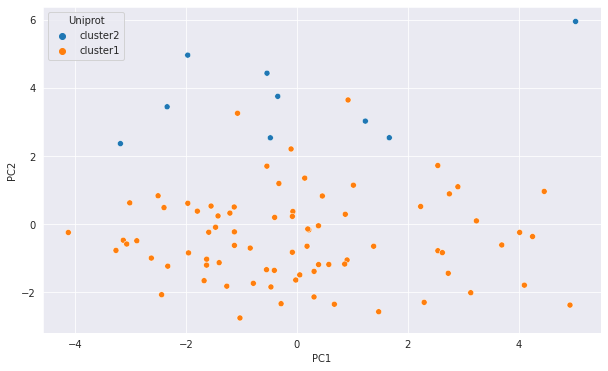

In [57]:
pca_plot_2d(df_aac, df_aac.index.to_series().transform(lambda x: "cluster2" if x in cluster2 else "cluster1"))

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

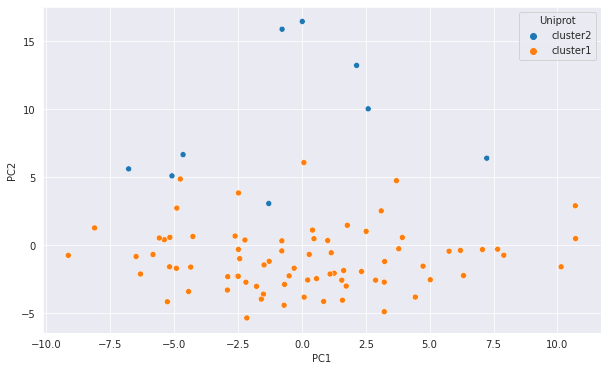

In [60]:
pca_plot_2d(df_paac, df_paac.index.to_series().transform(lambda x: "cluster2" if x in cluster2 else "cluster1"))

Again they all have high values in PC2. What is the protein in the top right in the AAC PCA plot?

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

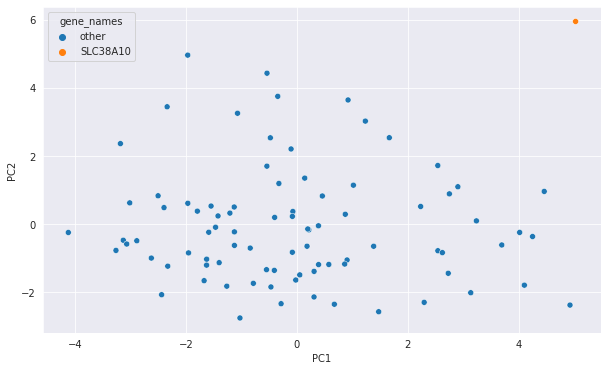

In [71]:
pca_plot_2d(df_aac, df.gene_names.transform(lambda x: "SLC38A10" if "SLC38A10" in x else "other"))

According to GO annotations, it's an antiporter in the Golgi membrane.

There are some symporters and antiporters in the dataset:

In [6]:
df.keywords_transport_related.value_counts()

Transport                     59
Symport;Transport             23
Antiport;Transport             4
Antiport;Symport;Transport     1
Name: keywords_transport_related, dtype: int64

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

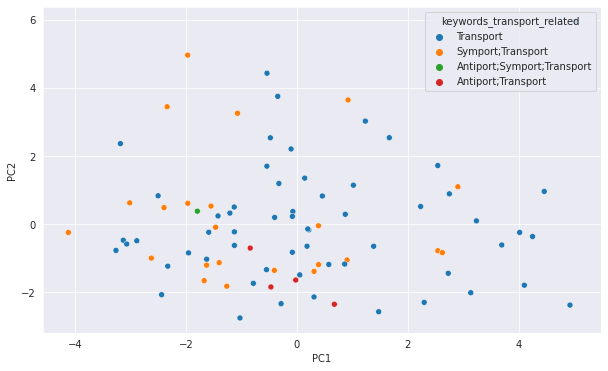

In [72]:
pca_plot_2d(df_aac, df.keywords_transport_related)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

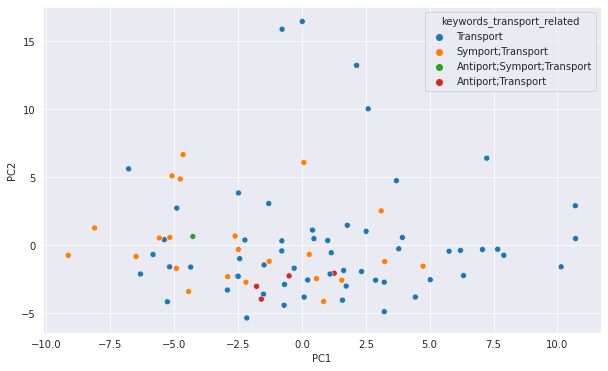

In [73]:
pca_plot_2d(df_paac, df.keywords_transport_related)

In terms of sequence PCA, nothing seems to stand out.

#### TCDB

This dataset is almost completely annotated with TCDB identifiers. Almost all of them are passive transporters in class 2.A. The class 8 protein is RBAT, which we already found earlier.

In [7]:
df.tcdb_class.value_counts()

2.A    84
0.0     2
8.A     1
Name: tcdb_class, dtype: int64

What is the protein with TCDB 8?

In [9]:
df[df.tcdb_class.str.startswith("8")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,8.A,9606,MAEDKSKRDSIEMSMKGCQTNNGFVHNEDILEQTPDPGSSTDNLKH...


This is rBAT, according to the TCDB entry a single-pass membrane protein with large intra- and extracellular domains. This protein is an outlier in the dataset.

What are the proteins without TCDB entry?

In [74]:
df[df.tcdb_class.str.startswith("0")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,0.0,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q8TD22,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN5,Sideroflexin-5,NaN,0.0,9606,MADTATTASAAAASAASASSDAPPFQLGKPRFQQTSFYGRFRHFLD...


Again two Sideroflexins, but they show similar properties to other SFXN proteins, which fit relatively well into the dataset, according to their structure and sequence.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

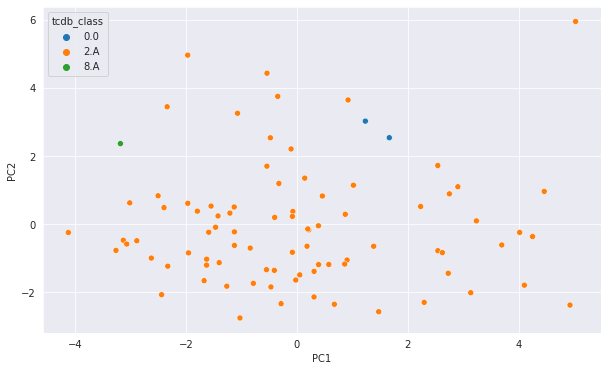

In [76]:
pca_plot_2d(df_aac, df.tcdb_class)


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

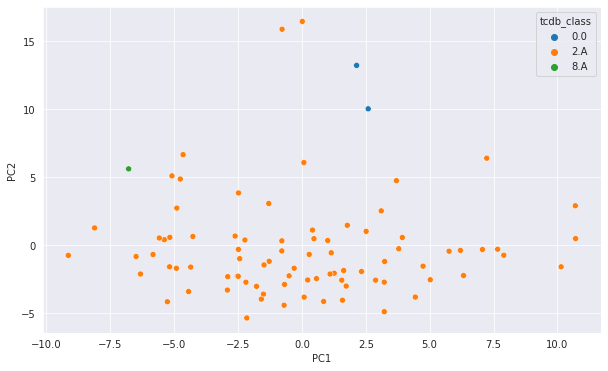

In [75]:
pca_plot_2d(df_paac, df.tcdb_class)

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

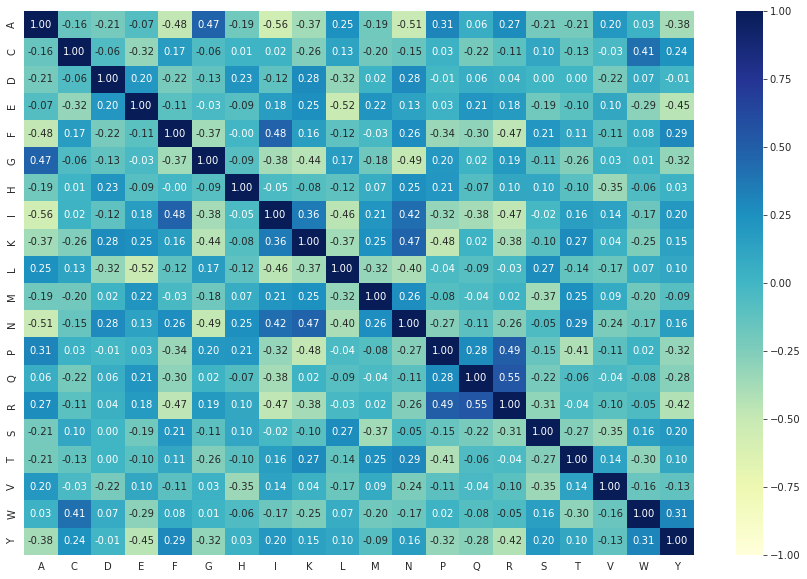

In [77]:
corr_heatmap(df_aac)

<AxesSubplot:>

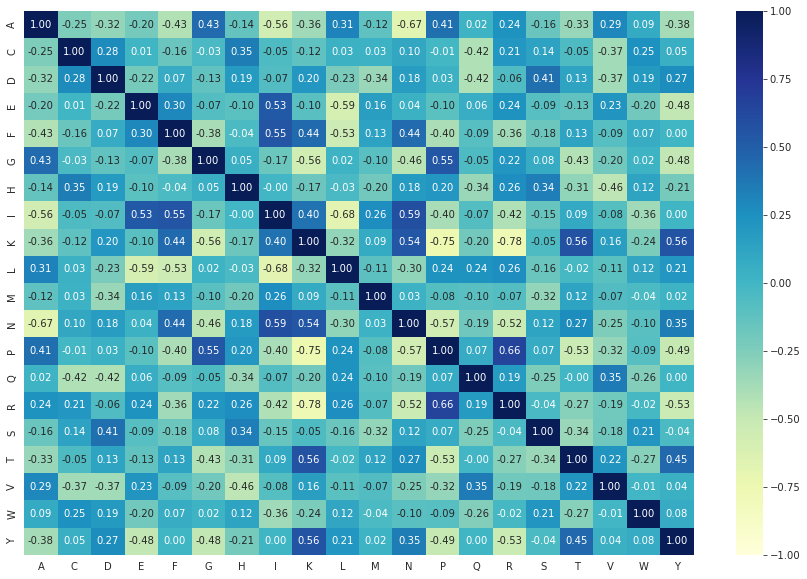

In [78]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

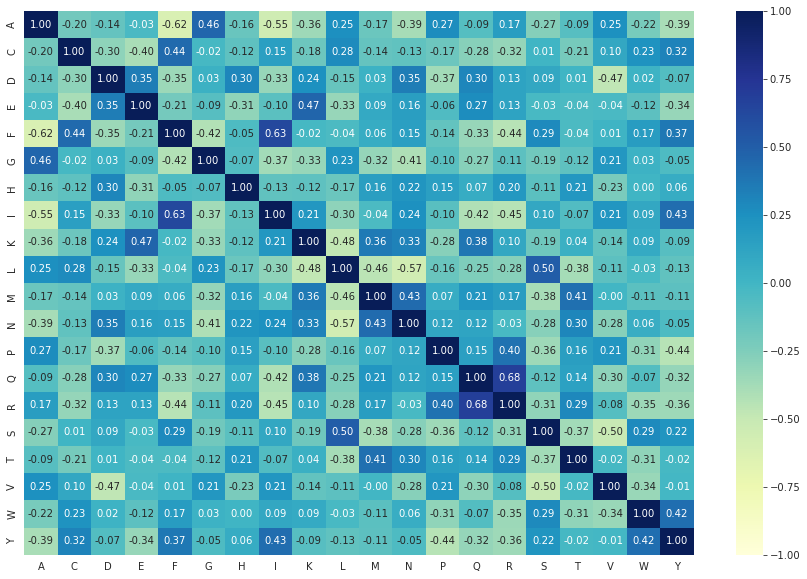

In [79]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

According to shapiro-wilk, most features follow a normal distribution. There is a slight deviation for D (Aspartic acid)

<AxesSubplot:>

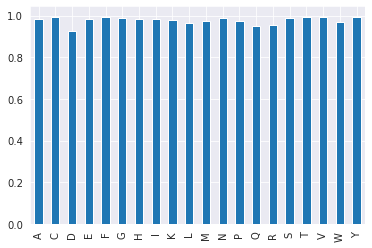

In [83]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

##### High Asp

There are three proteins with unusual Asp concentration:

<AxesSubplot:ylabel='Frequency'>

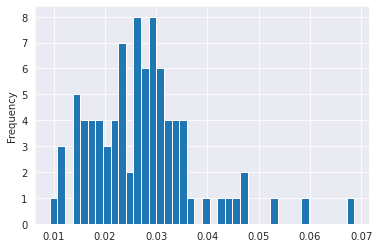

In [86]:
df_aac.D.plot.hist(bins=40)

In [87]:
df.loc[df_aac[df_aac.D > 0.05].index].join(df_aac.P, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,P
Uniprot,,,,,,,,,
Q96N87,Amino-acid transport;Neurotransmitter transport,Membrane;Transmembrane,Symport;Transport,SLC6A18 XTRP2,Inactive sodium-dependent neutral amino acid t...,2.A.22.6.4,2.A,9606,0.065287
Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,8.A,9606,0.040876
P08195,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,SLC3A2 MDU1,4F2 cell-surface antigen heavy chain (4F2hc) (...,2.A.3.8.188.A.9.2.2,2.A,9606,0.050794


One of them is RBAT, which we already classified as an outlier. 

SLC3A2/MDU1 seems to be a very well-known and -annotated transporter with many associated publications, it seem to be relevant in cancer research. 

SLC6A18/XTRP2 is inactive in human (https://pubmed.ncbi.nlm.nih.gov/26240152/), but the mouse orthlogogue transports amino acids. It might still be suitable for a training set, since it shows sequence properties of amino-acid transporters, except for the slightly higher Asp content. 

## Second analysis, after first outliers have been removed


In [88]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    verbose = True,
    tax_ids_filter = [9606],
    output_log = "../logs/human_amino_sugar_dataset.log",
    outliers=["Q9HBR0", "Q07837"]
)

In [89]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)
labels = df.keywords_transport

### PCA Plots



#### AAC

The data is not clearly separable with just the AAC

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

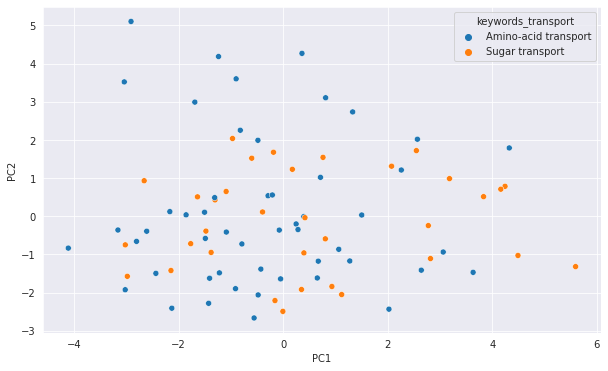

In [90]:
pca_plot_2d(df_aac, labels)

#### PAAC

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

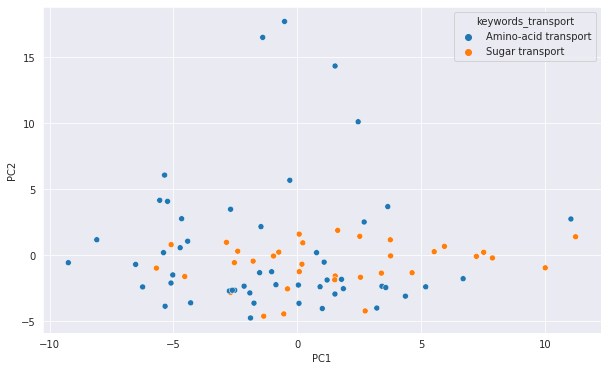

In [91]:
pca_plot_2d(df_paac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

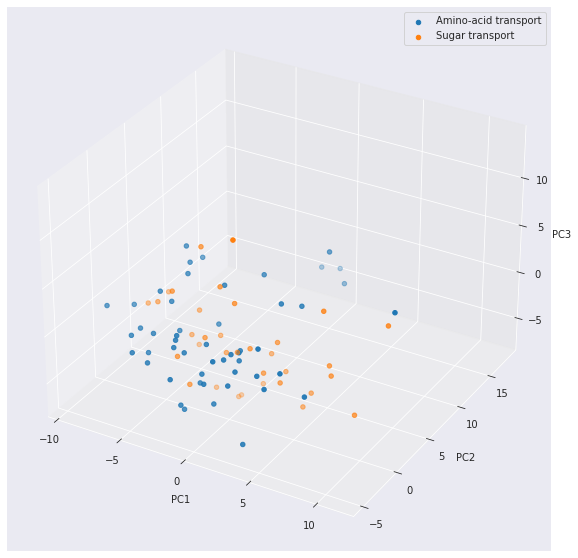

In [93]:
pca_plot_3d(df_paac, labels)

## Summary

We found one outlier in terms of structure (single pass membrane protein), and one in terms of sequence, that we found through PCA. 

In [96]:
outliers=["Q9HBR0", "Q07837"]

potential_outliers= df[df.protein_names.str.contains("Sideroflexin")].index.tolist()

potential_outliers

['Q9BWM7', 'Q96NB2', 'Q8TD22', 'Q6P4A7', 'Q9H9B4']